In [ ]:
import pandas as pd
import re
import numpy as np
from langdetect import detect
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt  
import seaborn as sns 

In [ ]:
def preprocess_text(text):
    """Preprocessing del testo"""
    if pd.isna(text):
        return ""
    
    # Converte in minuscolo
    text = text.lower()
    
    # Rimuove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Mantiene solo lettere, numeri, spazi e alcuni simboli
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Rimuove spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [58]:
# Carica il dataset
file_path = 'input/output.csv'
data = pd.read_csv(file_path)

print(data.isnull().sum())
# Rimuove righe vuote della colonna 'content'
print("Numero di righe prima del drop:", len(data))
data = data.dropna(subset=['content'])
print(data.isnull().sum())
print("Numero di righe prima del filtro:", len(data))

# Funzione per avere solo le recensioni scritte in inglese
def is_english_alphabet(text):
    
    try:
        # Minimo 10 caratteri per essere affidabile
        if len(text.strip()) < 10:
            return False
        
        language = detect(text)
        return language == 'en'
    
    except:
        # Se langdetect fallisce, return False (troppo ambiguo)
        return False

#Processa i dati
data['is_english'] = data['content'].apply(is_english_alphabet)
data['processed_content'] = data['content'].apply(preprocess_text)
data = data[data['is_english']]
print("Numero di righe dopo il filtro:", len(data))

print("Distribuzione delle classi:\n", data['is_positive'].value_counts())

id               0
app_id           0
content        428
author_id        0
is_positive      0
dtype: int64
Numero di righe prima del drop: 201151
id             0
app_id         0
content        0
author_id      0
is_positive    0
dtype: int64
Numero di righe prima del filtro: 200723
Numero di righe dopo il filtro: 138317
Distribuzione delle classi:
 is_positive
Negative    70753
Positive    67564
Name: count, dtype: int64


In [59]:
filtered_reviews = data[['content', 'processed_content', 'is_positive']].copy()
filtered_reviews.to_csv('recensioni_inglese_filtrate.csv', index=False)
print("File 'recensioni_inglese_filtrate.csv' salvato!")

File 'recensioni_inglese_filtrate.csv' salvato!


In [60]:
negative = data[data["is_positive"] == "Negative"]
positive = data[data["is_positive"] == "Positive"]

# Controlla la distribuzione
print("Prima del bilanciamento:")
print(data["is_positive"].value_counts())

# Numero da sottocampionare (qui riduco i negativi)
n_samples = len(positive)

negative_downsampled = resample(
    negative,
    replace=False,
    n_samples=n_samples,
    random_state=42
)

# Combina
data_balanced = pd.concat([negative_downsampled, positive])

# Shuffle
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Controlla la nuova distribuzione
print("Dopo il bilanciamento:")
print(data_balanced["is_positive"].value_counts())

Prima del bilanciamento:
is_positive
Negative    70753
Positive    67564
Name: count, dtype: int64
Dopo il bilanciamento:
is_positive
Negative    67564
Positive    67564
Name: count, dtype: int64


In [61]:
# Feature di interesse
X = data_balanced['processed_content']
y = data_balanced['is_positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## Addestramento e Confronto modelli

In [62]:
#Funzione da usare per la validaizone dei modelli
def validation(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    return scores.mean(), scores.std()

In [63]:
# Dizionario per salvare i risultati
model_results = {}

In [64]:
# Trasformare il testo in rappresentazioni numeriche
tfidf = TfidfVectorizer(stop_words="english",
                         max_features=25000,
                         ngram_range=(1, 3),
                         min_df=2,
                         max_df=0.90,
                         sublinear_tf=True
                         )
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [65]:
# Naive Bayes
print("\n--- NAIVE BAYES ---")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_cv_mean, nb_cv_std = validation(nb_model, X_train_tfidf, y_train, cv=5)


# Valutazione

print("Accuracy:", nb_accuracy)
print("\nClassification Report:\n", classification_report(y_test, nb_pred))
# Cross-validation per Naive Bayes
print(f"Cross-validation accuracy: {nb_cv_mean:.4f} (+/- {nb_cv_std * 2:.4f})")

model_results['Naive Bayes'] = {
    'accuracy': nb_accuracy,
    'cv_mean': nb_cv_mean,
    'cv_std': nb_cv_std,
    'predictions': nb_pred
}


--- NAIVE BAYES ---
Accuracy: 0.8446927649917364

Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.84      0.84     20270
    Positive       0.84      0.85      0.85     20269

    accuracy                           0.84     40539
   macro avg       0.84      0.84      0.84     40539
weighted avg       0.84      0.84      0.84     40539

Cross-validation accuracy: 0.8454 (+/- 0.0057)


In [66]:
# Modello 2: Logistic Regression
print("\n--- LOGISTIC REGRESSION ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_cv_mean, lr_cv_std = validation(lr_model, X_train_tfidf, y_train)

print(f"Accuracy: {lr_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, lr_pred))
print(f"Cross-validation accuracy: {lr_cv_mean:.4f} (+/- {lr_cv_std * 2:.4f})")

model_results['Logistic Regression'] = {
    'model': lr_model,
    'accuracy': lr_accuracy,
    'cv_mean': lr_cv_mean,
    'cv_std': lr_cv_std,
    'predictions': lr_pred
}



--- LOGISTIC REGRESSION ---
Accuracy: 0.8564
Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.85      0.85     20270
    Positive       0.85      0.87      0.86     20269

    accuracy                           0.86     40539
   macro avg       0.86      0.86      0.86     40539
weighted avg       0.86      0.86      0.86     40539

Cross-validation accuracy: 0.8573 (+/- 0.0100)


In [67]:
def create_visualizations(model_results, y_test):
    """Crea visualizzazioni complete"""
    print("\n📊 Creando visualizzazioni...")
    
    # Trova il miglior modello
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
    best_predictions = model_results[best_model_name]['predictions']
    
    # Crea figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analisi Sentiment - Risultati Modelli', fontsize=16, fontweight='bold')
    
    # 1. Confronto accuratezze
    models = list(model_results.keys())
    accuracies = [model_results[model]['accuracy'] for model in models]
    cv_means = [model_results[model]['cv_mean'] for model in models]
    cv_stds = [model_results[model]['cv_std'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = axes[0,0].bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8, color='skyblue')
    bars2 = axes[0,0].bar(x + width/2, cv_means, width, label='CV Mean', alpha=0.8, color='lightcoral')
    
    # Aggiungi error bars per CV
    axes[0,0].errorbar(x + width/2, cv_means, yerr=cv_stds, fmt='none', color='black', capsize=5)
    
    axes[0,0].set_xlabel('Modelli')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Confronto Accuratezza Modelli')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Aggiungi valori sopra le barre
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Confusion Matrix del miglior modello
    cm = confusion_matrix(y_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,1], cmap='Blues', 
                square=True, cbar_kws={'shrink': 0.8})
    axes[0,1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[0,1].set_ylabel('Actual')
    axes[0,1].set_xlabel('Predicted')
    
    # 3. Distribuzione predizioni
    pred_counts = pd.Series(best_predictions).value_counts()
    actual_counts = pd.Series(y_test).value_counts()
    
    x_pos = np.arange(len(pred_counts))
    axes[1,0].bar(x_pos - 0.2, actual_counts.values, 0.4, label='Actual', alpha=0.8, color='green')
    axes[1,0].bar(x_pos + 0.2, pred_counts.values, 0.4, label='Predicted', alpha=0.8, color='orange')
    axes[1,0].set_xlabel('Classi')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Distribuzione Classi: Actual vs Predicted')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(pred_counts.index)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Metriche dettagliate
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    metrics_data = []
    for model_name, results in model_results.items():
        pred = results['predictions']
        metrics_data.append({
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, pred),
            'Precision': precision_score(y_test, pred, pos_label='Positive'),
            'Recall': recall_score(y_test, pred, pos_label='Positive'),
            'F1-Score': f1_score(y_test, pred, pos_label='Positive')
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Grafico a barre delle metriche
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    for i, model in enumerate(models):
        values = [metrics_df[metrics_df['Model'] == model][metric].iloc[0] for metric in metrics_to_plot]
        axes[1,1].bar(x + i * width, values, width, label=model, alpha=0.8)
    
    axes[1,1].set_xlabel('Metriche')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Confronto Metriche di Performance')
    axes[1,1].set_xticks(x + width / 2)
    axes[1,1].set_xticklabels(metrics_to_plot)
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return best_model_name, metrics_df


📊 Creando visualizzazioni...


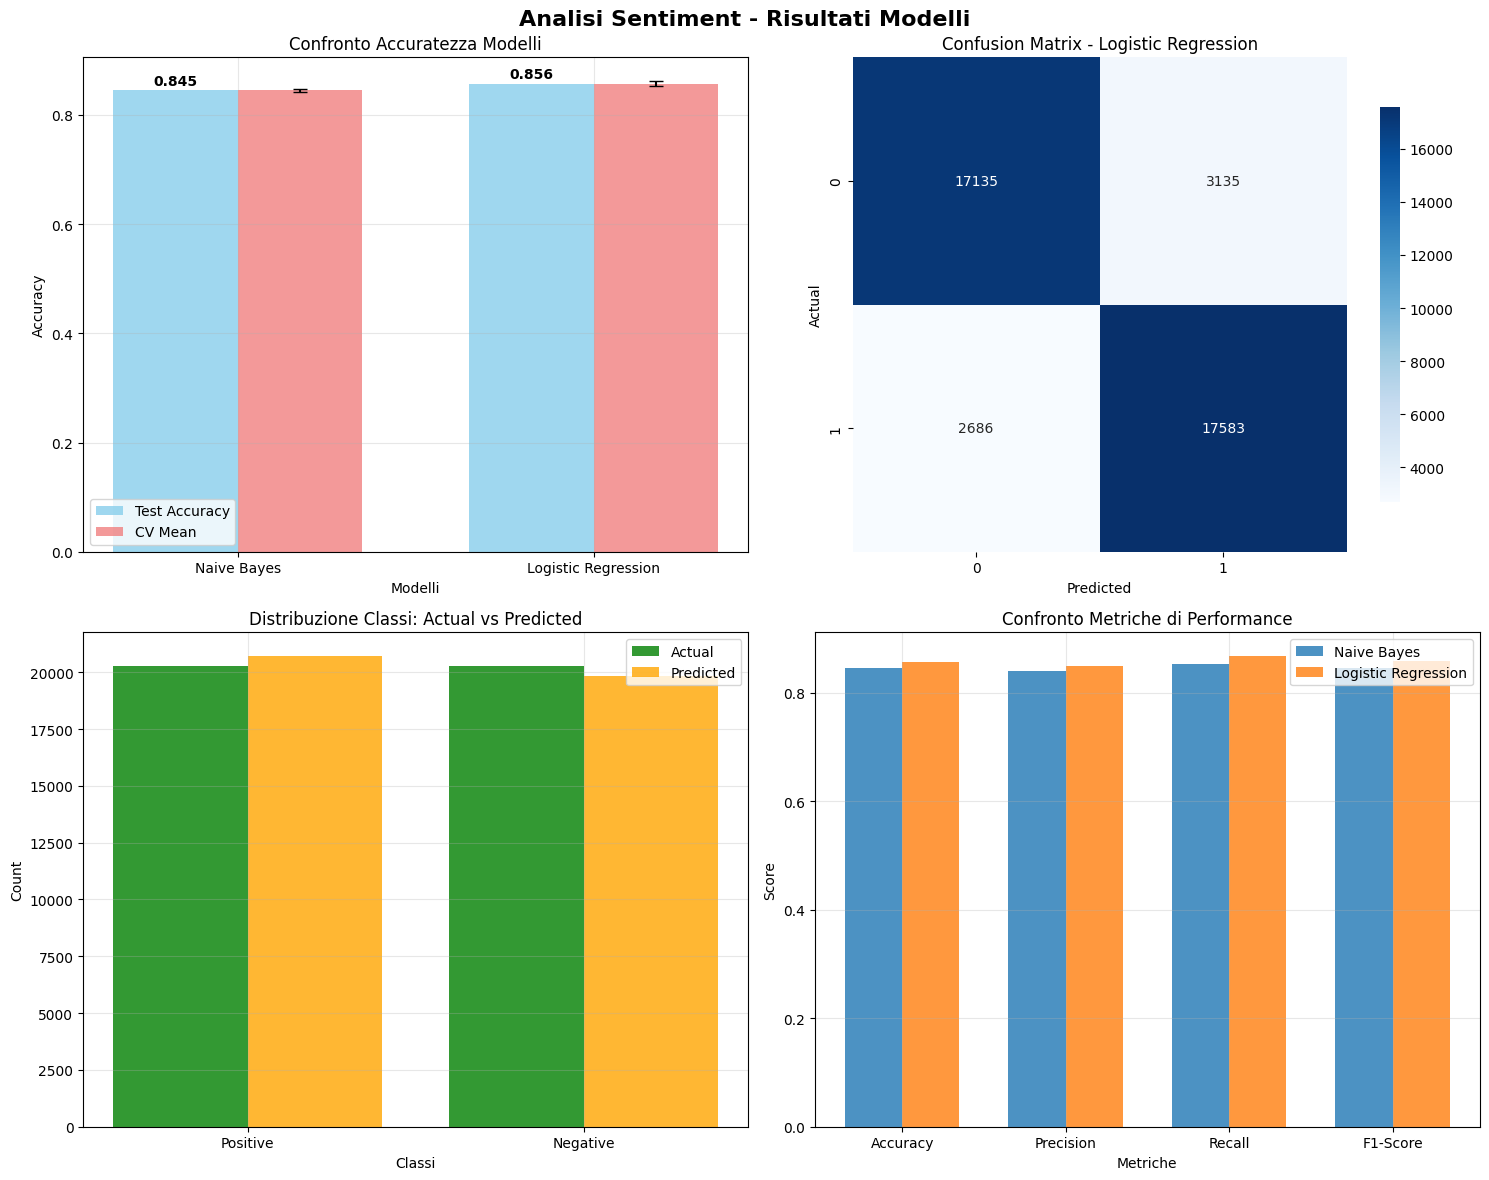

In [68]:
# Crea visualizzazioni
best_model_name, metrics_df = create_visualizations(model_results, y_test)

In [69]:
    # Mostra metriche dettagliate
print(f"\n🏆 MIGLIOR MODELLO: {best_model_name}")
print(f"Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
print("\n📊 Metriche dettagliate:")
print(metrics_df.round(4))


🏆 MIGLIOR MODELLO: Logistic Regression
Accuracy: 0.8564

📊 Metriche dettagliate:
                 Model  Accuracy  Precision  Recall  F1-Score
0          Naive Bayes    0.8447     0.8397  0.8520    0.8458
1  Logistic Regression    0.8564     0.8487  0.8675    0.8580


In [70]:
# Mostriamo alcune recensioni e la loro predizione
test_results = pd.DataFrame({
    'review': X_test,
    'predicted': nb_pred,
    'actual': y_test
}).reset_index(drop=True)

print(test_results.head(10)) 

                                              review predicted    actual
0  a must play for anyone ever if you like funny ...  Positive  Positive
1                             got killed by a zombie  Positive  Negative
2  if you cant run cs2 or if you just love older ...  Positive  Positive
3                        i cant shoot the alyx woman  Positive  Negative
4  great fun game simply awesome play with friend...  Positive  Positive
5  cs2 the next chapter of a legendary franchise ...  Positive  Positive
6                  valve please lock in thanks 33333  Negative  Negative
7  fixtf2 savetf2 this has gone too far as many h...  Negative  Negative
8  cs 2 crashes and i cant enter the game when th...  Negative  Negative
9  omg this dlc is the best but of half life dlc ...  Positive  Positive


In [71]:
# Errori: predetti positivi ma actually negativi
false_positives = test_results[(test_results['actual'] == 'Negative') & 
                              (test_results['predicted'] == 'Positive')]
print(f"\nFalsi Positivi (predetti Positive ma sono Negative): {len(false_positives)}")
if len(false_positives) > 0:
    print("Esempi:")
    for i, row in false_positives.head(3).iterrows():
        print(f"- {row['review'][:100]}...")

# Errori: predetti negativi ma actually positivi  
false_negatives = test_results[(test_results['actual'] == 'Positive') & 
                              (test_results['predicted'] == 'Negative')]
print(f"\nFalsi Negativi (predetti Negative ma sono Positive): {len(false_negatives)}")
if len(false_negatives) > 0:
    print("Esempi:")
    for i, row in false_negatives.head(3).iterrows():
        print(f"- {row['review'][:100]}...")


Falsi Positivi (predetti Positive ma sono Negative): 3296
Esempi:
- got killed by a zombie...
- i cant shoot the alyx woman...
- bro my computer exploded...

Falsi Negativi (predetti Negative ma sono Positive): 3000
Esempi:
- i mean its alright i do think it should be free if you have the original but apart from that its not...
- actually wish i paid for it...
- 4 autistic bastards gun each other down and maybe get to a checkpoint...


## Testing dati

In [ ]:

# Carica il nuovo dataset
new_file_path = 'input/new_reviews.csv'
new_data = pd.read_csv(new_file_path)

# Trasformazione dei testi con il TF-IDF usato in training
new_reviews_tfidf = tfidf.transform(new_data['content'])

# Predizione con il modello addestrato
new_predictions = lr_model.predict(new_reviews_tfidf)

# Aggiungi le predizioni al dataframe
new_data['predicted'] = new_predictions

# --- METRICHE DI TESTING ---
print("\n📊 Risultati sul set di test:\n")
print("Accuracy:", accuracy_score(new_data['label'], new_data['predicted']))
print("\nClassification Report:\n", classification_report(new_data['label'], new_data['predicted']))
print("\nConfusion Matrix:\n", confusion_matrix(new_data['label'], new_data['predicted']))

# --- VISUALIZZA ALCUNE RECENSIONI CON PREDIZIONI ---
print("\n📝 Nuove recensioni con predizioni:\n")
print(new_data[['content', 'label', 'predicted']].head(10).to_string(index=False))



📊 Risultati sul set di test:

Accuracy: 0.9122807017543859

Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.93      0.91        27
    Positive       0.93      0.90      0.92        30

    accuracy                           0.91        57
   macro avg       0.91      0.91      0.91        57
weighted avg       0.91      0.91      0.91        57


Confusion Matrix:
 [[25  2]
 [ 3 27]]

📝 Nuove recensioni con predizioni:

                                                    content    label predicted
      This product is amazing! It exceeded my expectations. Positive  Positive
           I am very disappointed. The quality is terrible. Negative  Negative
Fast delivery and great customer service. Highly recommend! Positive  Positive
The item arrived broken and the support team was unhelpful. Negative  Negative
                Good value for money. I would buy it again. Positive  Negative
       Terrible experience. Will not o